In [1]:
!pip3 install --user opencv-python
!rm ./output/*

In [2]:
from dataclasses import dataclass
from itertools import product
from pathlib import Path
from typing import Callable, NamedTuple, Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage as sk
import skimage.io as skio
from numpy import ndarray
from PIL import Image

# Input images

In [3]:
data_dir, extra_dir, out_dir = Path("data"), Path("extra"), Path("output")
adjust_dir = Path("output/adjust")
out_dir.mkdir(parents=True, exist_ok=True)

low_res_imgs = list(data_dir.glob("*.jpg"))
high_res_imgs = list(data_dir.glob("*.tif"))
extra_imgs = list(extra_dir.glob("*"))

print(f"number of images = {len(low_res_imgs)}")
print(f"number of images = {len(high_res_imgs)}")
print(f"number of images = {len(extra_imgs)}")

number of images = 5
number of images = 12
number of images = 0


# Aligning Channels

## Helper Functions

In [4]:
class Displacement(NamedTuple):
    """Start of each color as a row."""

    r: int
    g: int
    b: int = 0


class Offset(NamedTuple):
    row: int = 0
    col: int = 0
        
class ChannelSize(NamedTuple):
    row: int = 0
    col: int = 0

class Pic(NamedTuple):
    r: np.ndarray
    r_start
    g: np.ndarray
    g_start
    b: np.ndarray
    b_start
    h: int
    w: int

NameError: name 'r_start' is not defined

In [ ]:
def est_channel_height(img: ndarray):
    return img.shape[0] // 3

def est_channel_width(img: ndarray):
    return img.shape[1]

def max_channel_height(img: Pic):
    return min(img.r.shape[0], img.b.shape[0], img.g.shape[0])

def max_channel_width(img: Pic):
    return min(img.r.shape[1], img.b.shape[1], img.g.shape[1])

def channels(img, disp: Displacement, h:int, w:int) -> Tuple[ndarray, ndarray, ndarray]:
    # create channel matrices
    # print(B_start, G_start, R_start, h, w)
    r, g, b = disp.r, disp.g, disp.b
    B_mat = img[b : b + h, :w]
    G_mat = img[g : g + h, :w]
    R_mat = img[r : r + h, :w]
    return R_mat, G_mat, B_mat

In [ ]:
# Returns a sub_matrix extracted from img
def sub_image(
    img: ndarray,
    start: int,
    offset: Offset = Offset(),
    pad_val: float = np.inf,
) -> ndarray:
    # initialize entries of result to 'inf'
    h, w = est_channel_height(img), est_channel_width(img)
    result = np.full((h - 2 * offset.row, w - 2 * offset.col), pad_val)

    # extract sub_matrix from img
    a = img[
        start + offset.row : start + h - offset.row,
        0 + offset.col : 0 + w - offset.col,
    ]
    result[: a.shape[0], : a.shape[1]] = a
    return result

## Alignment Algorithms

In [235]:
# Returns the chosen algorithm
def align(
    metric=ssd,
    img: ndarray,
    displacement_estimate: Displacement = None,
    window: int = 20,
    offset=Offset(row=20, col=20),
) -> Displacement:

    h, _ = est_channel_height(img), est_channel_width(img)
    B_start = 0
    G_start = h
    R_start = 2 * h

    b = sub_image(img, B_start, offset)
    # find displacement for G channel
    score = {}
    for d in range(-window, window):
        g = sub_image(img, G_start + d, offset)
        score[d] = ssd(b, g)
    G_start += min(score)
    # find displacement for R channel
    score.clear()
    for d in range(-window, window):
        r = sub_image(img, R_start + d, offset)
        score[d] = metric(b, r)
    R_start += min(score)
    return Displacement(g=G_start, r=R_start)

### Basic

In [51]:
# Returns alignment index by simply dividing the image in 3
def align_basic(img: ndarray) -> Displacement:
    G_start = channel_height(img)  # floor division to get integer indices
    R_start = channel_height(img) * 2
    return Displacement(g=G_start, r=R_start)

### SSD

In [239]:
# Returns the ssd between matrix a and matrix b
def ssd(a: ndarray, b: ndarray) -> float:
    return np.sum((a - b) ** 2)

### NCC

In [242]:
# Returns the ncc between matrix a and matrix b
def ncc(a: ndarray, b: ndarray) -> float:
    assert(a.shape == b.shape)
    s = np.array([a[r] @ b[r] for r in range(a.shape[0])])
    return np.sum(s)

## Image Pyramid

In [54]:
def pyramid(
    img: ndarray, *args
) -> Displacement:
    if img.size < 1500 * 500:
        return align(img, *args)
    im_resize = cv2.resize(img, (img.shape[0] // 2, img.shape[1] // 2))
    new_pyr = pyramid(im_resize, align_metric, *args)
    g_est, r_est = new_pyr.g, new_pyr.r
    G_start = int(np.round(g_est / im_resize.shape[0] * img.shape[0]))
    R_start = int(np.round(r_est / im_resize.shape[0] * img.shape[0]))
    return Displacement(g=G_start, r=R_start)

# Test and Display Results

In [227]:
def compute(img, out_dir:Path, algorithm, *args, show=False):
    # read input file
    im = cv2.imread(str(img), cv2.IMREAD_GRAYSCALE)
    print(img.name)
    if show:
        plt.figure()
        plt.imshow(im, cmap=plt.get_cmap("gray"))

    # initiialize variables
    h, w = est_channel_height(im), est_channel_width(im)
    result = Pic()
    
    # compute displacements
    d = Displacement(0, 0, 0)
    #d = pyramid(im, algorithm)
    d = align(im, ssd, )
    print(f'"({d.b}, 0), ({d.g}, 0), ({d.r}, 0)"')
    
    # combine channels and display result
    R_mat, G_mat, B_mat = channels(im, d, h, w)
    result = np.dstack([R_mat, G_mat, B_mat])
    if show:
        plt.figure()
        plt.title(f'"{R_mat.shape}, {G_mat.shape}, {B_mat.shape}"')
        plt.imshow(result)

    # save the images
    fname = out_dir / img.stem
    Image.fromarray(result).save(fname, "PNG")
    return result

## Testing low resolution images

monastery.jpg
"(0, 0), (321, 0), (662, 0)"
monastery.jpg
"(0, 0), (321, 0), (662, 0)"
tobolsk.jpg
"(0, 0), (321, 0), (662, 0)"
tobolsk.jpg
"(0, 0), (321, 0), (662, 0)"
cathedral.jpg
"(0, 0), (321, 0), (662, 0)"
cathedral.jpg
"(0, 0), (321, 0), (662, 0)"


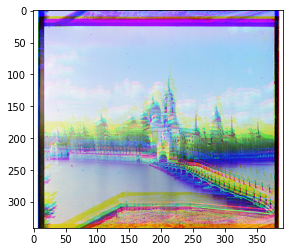

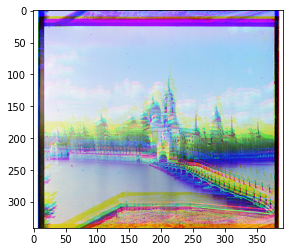

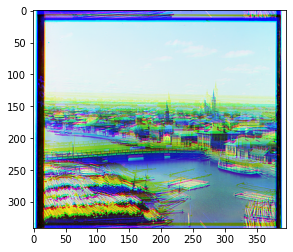

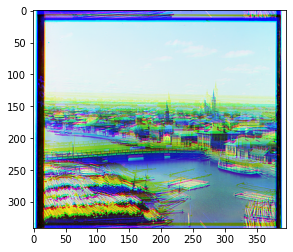

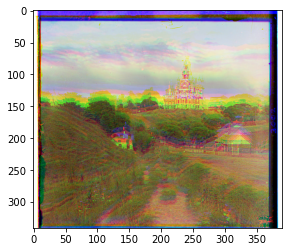

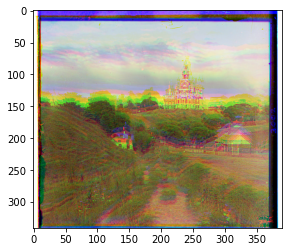

In [243]:
if __name__ == "__main__":
    for im in low_res_imgs:
        save_n_display(im, out_dir, align_basic)
        save_n_display(im, out_dir, align_ssd)

## Testing high resolution images

workshop.tif
"(0, 0), (3189, 0), (6398, 0)"
emir.tif
"(0, 0), (3189, 0), (6398, 0)"
three_generations.tif
"(0, 0), (3189, 0), (6398, 0)"
castle.tif
"(0, 0), (3229, 0), (6478, 0)"
melons.tif
"(0, 0), (3221, 0), (6462, 0)"
onion_church.tif
"(0, 0), (3195, 0), (6410, 0)"
train.tif
"(0, 0), (3218, 0), (6456, 0)"
icon.tif
"(0, 0), (3224, 0), (6468, 0)"
self_portrait.tif
"(0, 0), (3231, 0), (6482, 0)"
harvesters.tif
"(0, 0), (3198, 0), (6416, 0)"
lady.tif
"(0, 0), (3192, 0), (6404, 0)"


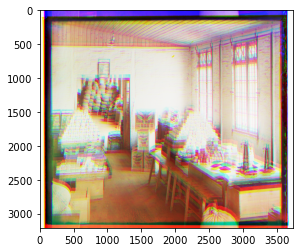

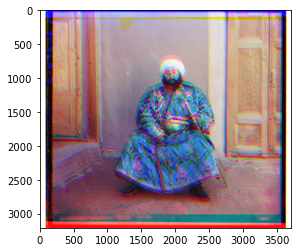

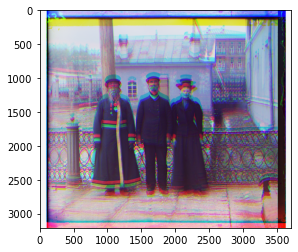

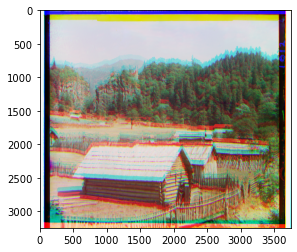

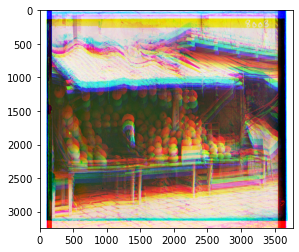

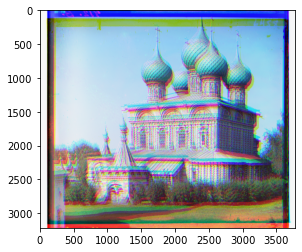

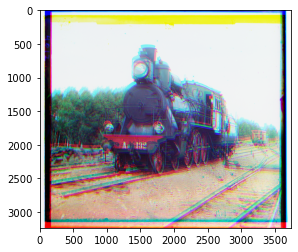

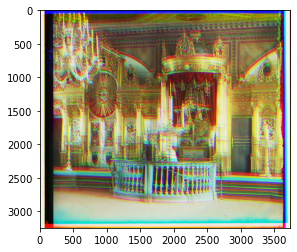

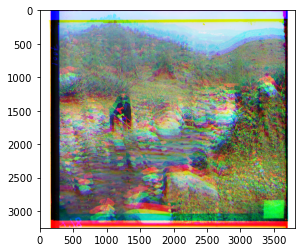

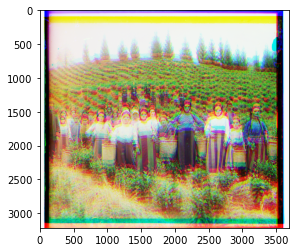

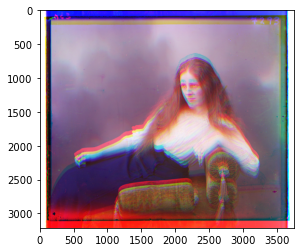

In [229]:
if __name__ == "__main__":
    for im in high_res_imgs:
        save_n_display(im, out_dir, align_ssd)

workshop.tif
"(0, 0), (2785, 0), (5977, 0)"
emir.tif
"(0, 0), (2793, 0), (6002, 0)"
three_generations.tif
"(0, 0), (2779, 0), (5979, 0)"
castle.tif
"(0, 0), (2833, 0), (6082, 0)"
melons.tif
"(0, 0), (2827, 0), (6067, 0)"
onion_church.tif
"(0, 0), (2802, 0), (6007, 0)"
train.tif
"(0, 0), (2811, 0), (6032, 0)"
icon.tif
"(0, 0), (2810, 0), (6042, 0)"
self_portrait.tif
"(0, 0), (2826, 0), (6067, 0)"
harvesters.tif
"(0, 0), (2790, 0), (6005, 0)"
lady.tif
"(0, 0), (2789, 0), (5987, 0)"


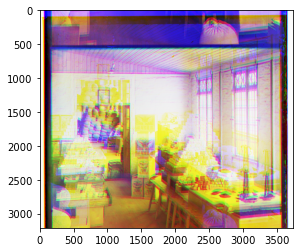

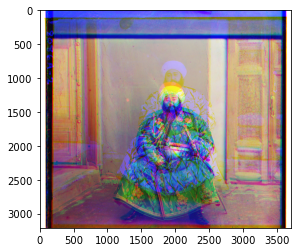

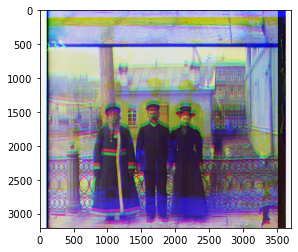

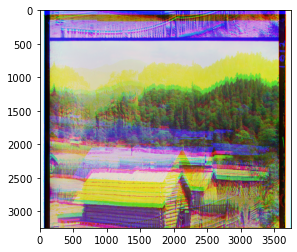

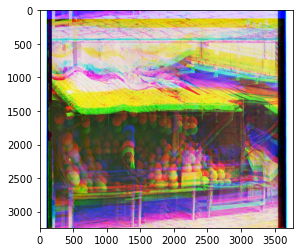

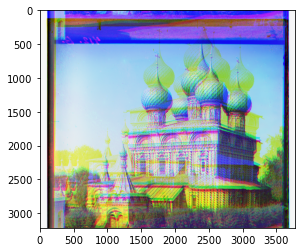

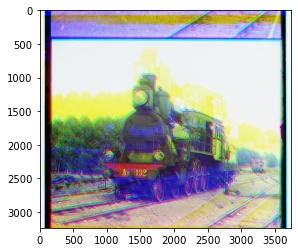

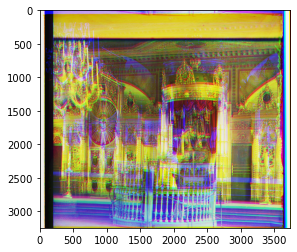

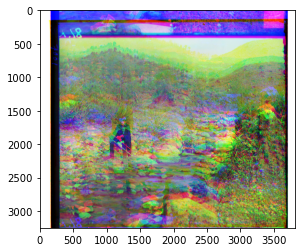

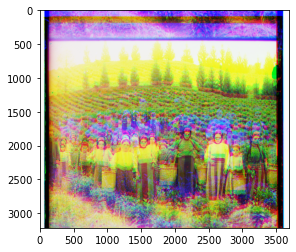

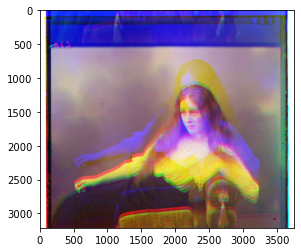

In [226]:
if __name__ == "__main__":
    for im in high_res_imgs:
        save_n_display(im, out_dir, align_ssd)

## Testing extra images

cotton.tif
"(0, 0), (2814, 0), (6040, 0)"
church.tif
"(0, 0), (2851, 0), (6114, 0)"
makhrovye.jpg
"(0, 0), (321, 0), (662, 0)"
kapri.jpg
"(0, 0), (321, 0), (662, 0)"


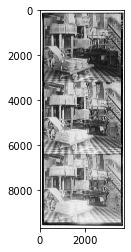

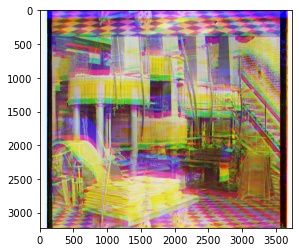

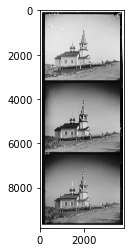

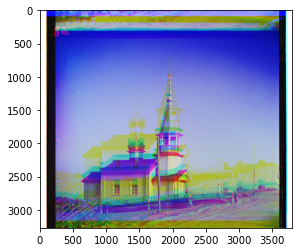

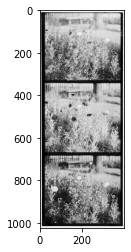

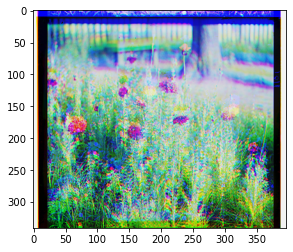

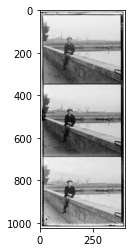

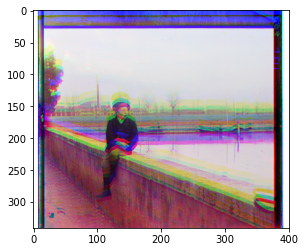

In [216]:
if __name__ == "__main__":
    for im in extra_imgs:
        save_n_display(im, out_dir, align_ssd)

# Adjustments

## Normalize Exposures

In [136]:
# takes in a matrix with values within [1,0],
# and transforms it so that the minimum value becomes 0, maximum value becomes 1
def fix_exposure(mat: ndarray, show=False) -> None:
    unit_len = np.max(mat) - np.min(mat)
    mat = (mat - np.amin(mat)) / unit_len
    if show:
        plt.imshow(mat)

## Crop Borders

In [137]:
def find_border(mat, axis):
    # zero pad mat at rightmost and bottom
    mat_padded = np.pad(mat, ((0, 1), (0, 1), "constant", 0))
    
    val_r, val_c = [], []
    # find row border
    for i in range[mat.shape[0]]:
        val_r[i, i + 1] = mat_padded[i] @ mat_padded[i + 1]
    r_cutoff = np.unravel_index(np.argmin(val))[1]
    # find col border
    for i in range[mat.shape[1]]:
        val_c[i, i + 1] = mat_padded[:, [i]] @ mat_padded[:, [i + 1]]
    c_cutoff = np.unravel_index(np.argmin(val))[1]
    return [r_cutoff, c_cutoff]

def crop_borders(mat, show=False):
    find_border(mat)
    if show:
        plt.imshow(balanced_im)

## Auto White Balance (AWB)

In [144]:
# Automatic (AWB)
# • Grey World: force average color of scene to grey
# • White World: force brightest object to white

def awb_grey(im, show=False):
    # Compute the mean color over the entire image
    avg_color = np.mean(im)

    # Scale the averge color to be grey (0.5)
    scaling = 0.5 / avg_color

    # Apply the scaling to the entire image
    balanced_im = im * scaling
    if show:
        plt.imshow(balanced_im)
    im = balanced_im

def awb_white(im, show=False):
    # Compute the brightest color over the entire image
    brightest_color = np.amax(im)

    # Scale the brightest color to be white (1.0)
    scaling = 1.0 / brightest_color

    # Apply the scaling to the entire image
    balanced_im = im * scaling
    if show:
        plt.imshow(balanced_im)
    im = balanced_im

## Apply Adjustments

In [187]:
# im = low_res_imgs[:1]
# plt.show(im)

# awb_grey(im, show=True)
# #awb_white(im, show=True)
# fix_exposure(im, show=True)
# #crop_borders(im, show=True)

# im_aligned = save_n_display(input, out_dir, align_ssd)

AttributeError: module 'cv2.cv2' has no attribute 'low_res_imgs'

"The displacements are: Displacement(r=682, g=341, b=0)"


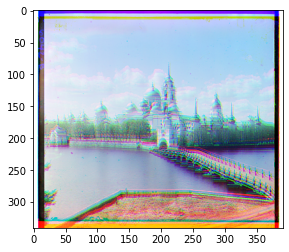

In [150]:
im_aligned = save_n_display(low_res_imgs[:1], out_dir, align_basic)
#awb_grey(im_aligned, show=True)
awb_white(im_aligned, show=True)
fix_exposure(im_aligned, show=True)
#crop_borders(im_aligned, show=True)